# Quantitative experiments with Hurricane Damage Estimation dataset
This dataset contains information about satellite images from the Greater Houston area after Hurricane Harvey in 2017. Each image has been labelled as either "Flooded/Damaged" or "Undamaged" https://cutt.ly/kQ1n3kE

In [1]:
import sys
sys.path.append('C:\\Users\\iamollas\\Desktop\\Altruist New')
data_path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Preprocessed Data\\D3\\'
model_path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Models\\D3\\'

In [2]:
import random
import time
import csv
import warnings
import json
import lime.lime_image as li
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.applications import VGG16
import keras
import json
from keras.models import Model
from innvestigate.utils.keras import checks
import innvestigate
import innvestigate.utils as iutils
from altruist import Altruist
from meta_explain import MetaExplain
from sklearn.preprocessing import maxabs_scale
import numpy as np
np.seterr(invalid='ignore')
warnings.filterwarnings("ignore")


Using TensorFlow backend.


We will now load the Hurricane Damage Estimation Dataset. Run the following lines only once. It will prepare and save the data. Then just run the code in the next cell!

In [3]:
#hurricane = Dataset()
#train_images, train_labels, test_images, test_labels, val_images, val_labels = hurricane.load_hurricane()

#train_images = train_images/255
#test_images = test_images/255
#val_images = val_images/255
#import pickle
#data = [train_images, train_labels]
#with open('D3_data_train.pickle', 'wb') as outfile:
#    pickle.dump(data, outfile, protocol=pickle.HIGHEST_PROTOCOL)

#data = [test_images, test_labels]
#with open('D3_data_test.pickle', 'wb') as outfile:
#    pickle.dump(data, outfile, protocol=pickle.HIGHEST_PROTOCOL)

#data = [val_images, val_labels]
#with open('D3_data_val.pickle', 'wb') as outfile:
#    pickle.dump(data, outfile, protocol=pickle.HIGHEST_PROTOCOL)

Here, we load the saved-preprocessed data!

In [4]:
import pickle
data_path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Preprocessed Data\\D3\\'
model_path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Models\\D3\\'
with open(data_path+'D3_data_train.pickle', 'rb') as handle:
    train = pickle.load(handle)
    train_images = train[0]
    train_labels = train[1]
with open(data_path+'D3_data_test.pickle', 'rb') as handle:
    test = pickle.load(handle)
    test_images = test[0]
    test_labels = test[1]
with open(data_path+'D3_data_val.pickle', 'rb') as handle:
    val = pickle.load(handle)
    val_images = val[0]
    val_labels = val[1]

In [5]:
train_images.shape, test_images.shape, val_images.shape

((20000, 128, 128, 3), (9000, 128, 128, 3), (4000, 128, 128, 3))

And we will build two neural network models. One linear and one non-linear, and one uneccessary complex model.

In [6]:
from keras.regularizers import l2

linear_input = Input(shape=(train_images[0].shape))
linear_hidden = Flatten()(linear_input)
linear_output = Dense(1, activation='sigmoid')(linear_hidden)
linear_neural = Model(linear_input, linear_output)
linear_neural.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

neural_input = Input(shape=(train_images[0].shape))
neural_hidden = Conv2D(32, (3, 3), strides=(1, 1), padding='same',
                       activation='relu', kernel_regularizer=l2(0.0005))(neural_input)
neural_hidden = BatchNormalization()(neural_hidden)
neural_hidden = MaxPool2D(pool_size=(2, 2))(neural_hidden)
neural_hidden = Dropout(0.6)(neural_hidden)
neural_hidden = Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                       activation='relu', kernel_regularizer=l2(0.0005))(neural_hidden)
neural_hidden = BatchNormalization()(neural_hidden)
neural_hidden = MaxPool2D(pool_size=(2, 2))(neural_hidden)
neural_hidden = Dropout(0.6)(neural_hidden)
neural_hidden = Conv2D(128, (3, 3), strides=(1, 1), padding='same',
                       activation='relu', kernel_regularizer=l2(0.0005))(neural_hidden)
neural_hidden = BatchNormalization()(neural_hidden)
neural_hidden = MaxPool2D(pool_size=(2, 2))(neural_hidden)
neural_hidden = Flatten()(neural_hidden)
neural_hidden = Dropout(0.6)(neural_hidden)
neural_output = Dense(1, activation='sigmoid')(neural_hidden)
neural = Model(neural_input, neural_output)
neural.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy'])

complex_net = VGG16(input_shape=(
    train_images[0].shape), include_top=False, weights='imagenet')
for layer in complex_net.layers:
    layer.trainable = False
complex = complex_net.output
complex = GlobalAveragePooling2D()(complex)
complex_output = Dense(1, activation='sigmoid')(complex)
complex_neural = Model(complex_net.input, complex_output)
complex_neural.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

models = {'lNN': linear_neural, 'NN': neural, 'cNN': complex_neural}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Let's evaluate our models!

In [7]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def compute_scores(name, y_test, y_pred):
    if type(y_pred[0]) == type(np.ndarray([1])):
        y_pred = np.array([1 if i[0] > 0.5 else 0 for i in y_pred])
    print(name)
    print('\t', 'F1:', f1_score(y_test, y_pred, average='macro'))
    print('\t', 'Precision:', precision_score(y_test, y_pred, average='macro'))
    print('\t', 'Recall:', recall_score(y_test, y_pred, average='macro'))
    print('\t', 'Accuracy:', accuracy_score(y_test, y_pred))

In [8]:
path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Models\\D3\\'
train = False
for name, model in models.items():
    if train:
        check_point = ModelCheckpoint(
            "D3_"+name+".hdf5", monitor="val_loss", verbose=0, save_best_only=True, mode="auto")
        if name == 'cNN':
            model.fit(train_images, train_labels, epochs=15, batch_size=32, shuffle=True,
                      validation_data=(val_images, val_labels), verbose=1, callbacks=[check_point])
            for layer in complex_net.layers[15:]:
                layer.trainable = True
            model.fit(train_images, train_labels, epochs=10, batch_size=32, shuffle=True,
                      validation_data=(val_images, val_labels), verbose=1, callbacks=[check_point])
        else:
            model.fit(train_images, train_labels, epochs=25, batch_size=32, shuffle=True,
                      validation_data=(val_images, val_labels), verbose=1, callbacks=[check_point])
            model.load_weights("D3_"+name+".hdf5")
    else:
        model.load_weights(path+"D3_"+name+".hdf5")
    y_pred = model.predict(test_images)
    compute_scores(name, test_labels, y_pred)


lNN
	 F1: 0.565476559909412
	 Precision: 0.5815972627376245
	 Recall: 0.6870625
	 Accuracy: 0.6933333333333334
NN
	 F1: 0.9322444719829415
	 Precision: 0.9102825488488284
	 Recall: 0.9578125
	 Accuracy: 0.9716666666666667
cNN
	 F1: 0.8529310393079833
	 Precision: 0.8131856855863842
	 Recall: 0.913375
	 Accuracy: 0.9323333333333333


We will prepare our predict functions to work well with our python scripts!

In [9]:
def predict_cNN(x):
    prediction = models['cNN'].predict(x)
    return [i[0] for i in prediction]

def predict_NN(x):
    prediction = models['NN'].predict(x)
    return [i[0] for i in prediction]

def predict_lNN(x):
    prediction = models['lNN'].predict(x)
    return [i[0] for i in prediction]

predict_functions = {'lNN': predict_lNN, 'NN': predict_NN, 'cNN': predict_cNN}


Let's prepare our explainers

In [10]:
def analyzer_generators(model):
    Xs = iutils.to_list(model.outputs)
    ret = []
    for x in Xs:
        layer, node_index, tensor_index = x._keras_history
        if checks.contains_activation(layer, activation="sigmoid"):
            if isinstance(layer, keras.layers.Activation):
                ret.append(layer.get_input_at(node_index))
            else:
                layer_wo_act = innvestigate.utils.keras.graph.copy_layer_wo_activation(
                    layer)
                ret.append(layer_wo_act(layer.get_input_at(node_index)))
    modified_model = Model(input=model.input, output=ret)
    modified_model.trainable = False
    modified_model.compile(
        optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    analyzer_IG = innvestigate.create_analyzer(
        'integrated_gradients', modified_model, reference_inputs=16*[0])
    analyzer_LRP = innvestigate.create_analyzer('lrp.z', modified_model)
    return [analyzer_IG, analyzer_LRP]


In [11]:
analyzer_NN = analyzer_generators(neural)
analyzer_lNN = analyzer_generators(linear_neural)
analyzer_cNN = analyzer_generators(complex_neural)


In [12]:
train_images_flat = train_images.copy().reshape((len(train_images), 128*128*3))
test_images_flat = test_images.copy().reshape((len(test_images), 128*128*3))
val_images_flat = val_images.copy().reshape((len(val_images), 128*128*3))
flat_features = [str('F_'+str(i)) for i in range(128*128)]

We prepare each interpretation technique to have the same format!

In [13]:
from skimage import segmentation

def fi_lNN(instance, predict_function):
    return np.array([i[0] for i in models['lNN'].get_weights()[0]]).reshape((128, 128, 3)).mean(axis=-1).reshape((128, 128))

def fi_IG_NN(instance, predict_function):
    a = analyzer_NN[0].analyze(np.array([instance]))[
        0].mean(axis=-1).reshape((128, 128))
    return a

def fi_LRP_NN(instance, predict_function):
    a = analyzer_NN[1].analyze(np.array([instance]))[
        0].mean(axis=-1).reshape((128, 128))
    return a

def fi_IG_lNN(instance, predict_function):
    a = analyzer_lNN[0].analyze(np.array([instance]))[0].reshape(
        (128, 128, 3)).mean(axis=-1).reshape((128, 128))
    return a

def fi_LRP_lNN(instance, predict_function):
    a = analyzer_lNN[1].analyze(np.array([instance]))[0].reshape(
        (128, 128, 3)).mean(axis=-1).reshape((128, 128))
    return a

def fi_IG_cNN(instance, predict_function):
    a = analyzer_cNN[0].analyze(np.array([instance]))[
        0].mean(axis=-1).reshape((128, 128))
    return a

def fi_LRP_cNN(instance, predict_function):
    a = analyzer_cNN[1].analyze(np.array([instance]))[
        0].mean(axis=-1).reshape((128, 128))
    return a

def image_no_segmentation(x):
    return segmentation.slic(x, n_segments=128*128)

explainer = li.LimeImageExplainer(feature_selection='none')

def fi_lime(instance, predict_function):
    def predict(x):
        a = predict_function(x)
        a = [[1-j, j] for j in a]
        return np.array(a)
    b = explainer.explain_instance(instance, predict, labels=(1,),
                                   top_labels=None, num_features=128*128, num_samples=100,
                                   segmentation_fn=image_no_segmentation).local_exp
    b = b[list(b.keys())[0]]
    b.sort()
    return np.array([i[1] for i in list(b)]).reshape((128, 128))

def fi_random(instance, predict_function):
    a1 = instance.reshape((128*128*3))
    seed = (a1.sum() +
            a1.mean())/100
    random.seed(seed)
    flat = np.array([random.randrange(-1000, 1000) /
                     1000 for i in range(len(flat_features))]).reshape((128, 128))
    return flat

We compute and save the interpretations for easier reproducibility

In [ ]:
from skimage.segmentation import slic
predict_functions = {'NN': predict_NN, 'cNN': predict_cNN}
segments = []
for instance in test_images[:1000]:
    segments.append(slic(instance, compactness=10, n_segments=30))

for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']

    importance_test = []
    count = 0
    for instance in test_images[:1000]:
        importance_instance = []
        labels = segments[count]
        for fi in fi_techniques:
            temp_int = maxabs_scale(fi(instance, neural_type))
            final_int = []
            for label in range(len(np.unique(labels))):
                final_int.append([])
            for dim in range(128):
                for dim2 in range(128):
                    final_int[labels[dim][dim2]].append(temp_int[dim][dim2])

            interpretation = []
            for label in range(len(np.unique(labels))):
                interpretation.append(np.array(final_int[label]).mean())

            importance_instance.append(interpretation)
        importance_test.append(importance_instance)
        count = count + 1

    importances = {'segments': np.array(
        segments).tolist(), 'test': str(importance_test)}
    with open('D3_'+neural_name+'.txt', 'w') as outfile:
        print(neural_name)
        json.dump(importances, outfile)

Our quantitative experiments!

## Starting with stability!

In [14]:
from inxai import *
gm = GlobalFeatureMetric()

In [15]:
from tqdm import tqdm

stability = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D3\\'
    with open(path+'D3_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    segments = np.array(importances['segments'])
    print(segments.shape)
    importance_test = np.array(json.loads(importances['test']))
    meta_explain = MetaExplain(None, segments)

    #print(importance_test[:,0].shape,test_images.shape)

    model_stability = []
    for idf,fi_name in enumerate(fi_names):
        model_stability.append(gm.stability(pd.DataFrame(test_images[:1000].reshape((1000,128*128*3))),
                                            importance_test[:,idf] ,epsilon=50))
    stability[neural_name] = model_stability
    
    print(neural_name)
    for idf, stability_score in enumerate(stability[neural_name]):
        print(fi_names[idf], np.mean(stability_score))

(1000, 128, 128)
lNN
Inherent 0.9837823033658326
IG 0.9836325747511673
LRP 0.9836325749603541
LIME 0.9908778696015427
RAND 0.9914305389096045
(1000, 128, 128)
NN
IG 0.993526883645488
LRP 0.9905101877135619
LIME 0.9893832608888771
RAND 0.9914305389096045
(1000, 128, 128)
cNN
IG 0.9941594401007929
LRP 0.9937038974504654
LIME 0.9900034496305299
RAND 0.9914305389096045


In [18]:
for neural_name, neural_type in predict_functions.items():
    print(neural_name)
    for idf, stability_score in enumerate(stability[neural_name]):
        print(fi_names[idf], np.mean(stability_score))

lNN
Inherent 0.9837823033658326
IG 0.9836325747511673
LRP 0.9836325749603541
LIME 0.9908778696015427
RAND 0.9914305389096045
NN
Inherent 0.993526883645488
IG 0.9905101877135619
LRP 0.9893832608888771
LIME 0.9914305389096045
cNN
Inherent 0.9941594401007929
IG 0.9937038974504654
LRP 0.9900034496305299
LIME 0.9914305389096045


In [20]:
meta_interpretations_test = {}
stability_meta = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['lNN'] = []
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['NN'] = []
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
        meta_interpretations_test['cNN'] = []
    meta_names = ['Average', 'Median', 'RuleBased']


    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D3\\'
    with open(path+'D3_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    segments = np.array(importances['segments'])
    print(segments.shape)
    importance_test = np.array(json.loads(importances['test']))
    meta_explain = MetaExplain(None, segments)

    print('Starting evaluation for', neural_name)
    noise = 'normal'
    delta = 0.0001

    my_altruist = Altruist(neural_type, train_images, fi_techniques, flat_features,
                                   level=noise, delta=delta, data_type='Image')
    for j in range(len(test_images[:1000])):
        segment = segments[j]
        meta_explain.feature_names = [
                    str('S_'+str(i)) for i in range(len(np.unique(segment)))]
        my_altruist.fis = len(fi_techniques)
        a = my_altruist.find_untruthful(test_images[j], importance_test[j], segment)
        b = np.array(a[-1])

        temp_meta = []
        temp_meta.append(meta_explain.meta_avg(b))
        temp_meta.append(meta_explain.meta_median(b))
        temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
        meta_interpretations_test[neural_name].append(temp_meta)
    
    model_stability = []
    for idf,meta_name in enumerate(meta_names):
        model_stability.append(gm.stability(pd.DataFrame(test_images[:1000].reshape((1000,128*128*3))),
        np.array(meta_interpretations_test[neural_name])[:,idf] ,epsilon=50))

    stability_meta[neural_name] = model_stability

    for idf, stability_score in enumerate(stability_meta[neural_name]):
        print(meta_names[idf], np.mean(stability_score))

(1000, 128, 128)
Starting evaluation for lNN
Average 0.9901351999109289
Median 0.986294294549066
RuleBased 0.9865925514587129
(1000, 128, 128)
Starting evaluation for NN
Average 0.9952897488152085
Median 0.9952612733813893
RuleBased 0.9947007338995705
(1000, 128, 128)
Starting evaluation for cNN
Average 0.995895531932499
Median 0.9958033499141569
RuleBased 0.9953153235714352


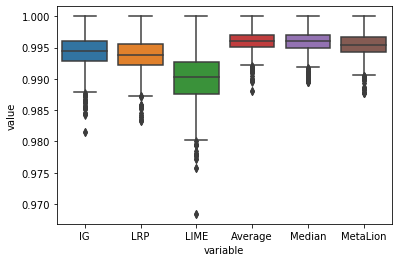

In [21]:
import seaborn as sns
lip_df = pd.DataFrame({'IG':stability['cNN'][0], 'LRP':stability['cNN'][1], 'LIME':stability['cNN'][2], # 'RAND':stability['cNN'][3], 
                        'Average':stability_meta['cNN'][0], 'Median':stability_meta['cNN'][1], 'MetaLion':stability_meta['cNN'][2]})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df))

In [22]:
lip_df_lnn = pd.DataFrame({'IG':stability['lNN'][1], 'LRP':stability['lNN'][2], 'LIME':stability['lNN'][3], 'RAND':stability['lNN'][4]})
lip_df_nn = pd.DataFrame({'IG':stability['NN'][0], 'LRP':stability['NN'][1], 'LIME':stability['NN'][2], 'RAND':stability['NN'][3]})
lip_df_cnn = pd.DataFrame({'IG':stability['cNN'][0], 'LRP':stability['cNN'][1], 'LIME':stability['cNN'][2], 'RAND':stability['cNN'][3]})

In [25]:
consistency = {}
for idf,fi_name in enumerate(['IG', 'LRP', 'LIME', 'RAND']):
    all_importance_tests = []
    for neural_name, neural_type in predict_functions.items():

        path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D3\\'
        with open(path+'D3_'+neural_name+'.txt') as json_file:
            importances = json.load(json_file)
        segments = np.array(importances['segments'])
        importance_test = np.array(json.loads(importances['test']))

        if neural_name == 'lNN':
            all_importance_tests.append(importance_test[:1000,1:])
        else:
            all_importance_tests.append(importance_test[:1000])
    all_importance_tests = np.array(all_importance_tests)
    consistency[fi_name] = gm.consistency(all_importance_tests[:,:,idf])
    print(fi_name, np.mean(consistency[fi_name]))

IG 0.7553028721754538
LRP 0.7511142071161857
LIME 0.8297617897971631
RAND 1.0


In [26]:
consistency_meta = {}
for idf, meta_name in enumerate(meta_names):
    all_importance_tests = []
    for neural_name, neural_type in predict_functions.items():
        all_importance_tests.append(np.array(meta_interpretations_test[neural_name]))
    all_importance_tests = np.array(all_importance_tests)
    consistency_meta[meta_name] = gm.consistency(all_importance_tests[:,:,idf])
    print(meta_name, np.mean(consistency_meta[meta_name]))

Average 0.8361085791776848
Median 0.7847739035982357
RuleBased 0.8115512949271204


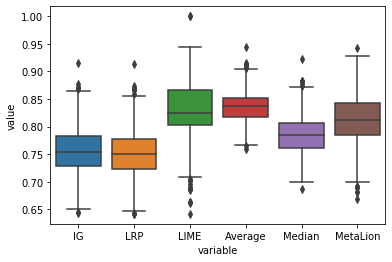

In [27]:
import seaborn as sns
con_df = pd.DataFrame({'IG':consistency['IG'], 'LRP':consistency['LRP'], 'LIME':consistency['LIME'], #'RAND':consistency['RAND'], 
                        'Average':consistency_meta['Average'], 'Median':consistency_meta['Median'], 'MetaLion':consistency_meta['RuleBased']})
sns.boxplot(x="variable", y="value", data=pd.melt(con_df))

In [28]:
import seaborn as sns
con_df_models = pd.DataFrame({'IG':consistency['IG'], 'LRP':consistency['LRP'], 'LIME':consistency['LIME'], 'RAND':consistency['RAND']})
    

In [29]:
#This is a tough one! Measuring AUPRC for the meta in inXAI technique

In [43]:
test_images[:1000].reshape((1000,128*128*3)).shape, len(flat_features)

((1000, 49152), 16384)

In [ ]:
importance_test[0][1]

In [ ]:
from sklearn.compose import ColumnTransformer
pd_x_test = pd.DataFrame(test_images[:1000].reshape((1000,128*128*3)), columns=['S'+str(i) for i in range(128*128*3)])
ct = ColumnTransformer([('_INXAI_normal_noise_perturber', NormalNoisePerturber(scale=2),pd_x_test.columns)])
auprc = {}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D3\\'
    with open(path+'D3_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    segments = np.array(importances['segments'])
    print(segments.shape)
    importance_test = np.array(json.loads(importances['test']))
    meta_explain = MetaExplain(None, segments)

    new_tests = []
    for instan in range(1000):
        new_test = []
        for inter in range(len(fi_techniques)):
            new_interpretation = []
            for i in range(128):
                for j in range(128):
                    new_interpretation.append(importance_test[instan][inter][segments[instan][i][j]])
            new_interpretation = np.array(new_interpretation).reshape((128,128))
            new_interpretation = np.repeat(new_interpretation[:, :, np.newaxis], 3, axis=2)
            new_test.append(new_interpretation)
        new_tests.append(new_test)
    new_tests = np.array(new_tests)
    print(importance_test.shape)
    print('Starting evaluation for', neural_name)
    model_auprc = []
    for idf,fi_name in tqdm(enumerate(fi_names)):
        print('watch me!')
        mean_fi = np.array(new_tests[:,idf]).reshape((1000,128*128*3)).mean(axis=0)
        model_auprc.append(gm.gradual_perturbation(model=models[neural_name], X=pd_x_test, y=test_labels[:1000], column_transformer=ct, importances_orig=mean_fi, 
                                        resolution=50,  count_per_step=10, plot=False, task='c', reshape=(128,128,3)))
    auprc[neural_name] = model_auprc

In [102]:
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    print(neural_name)
    for idf, auprc_score in enumerate(auprc[neural_name]):
        print(fi_names[idf], np.mean(auprc_score))

lNN
Inherent 0.16884000000000005
IG 0.17028800000000005
LRP 0.16953800000000002
LIME 0.16910200000000003
RAND 0.16932800000000003
NN
IG 0.07918599999999999
LRP 0.07890399999999999
LIME 0.07941999999999999
RAND 0.078224
cNN
IG -0.048026000000000055
LRP -0.048224000000000045
LIME -0.04738600000000005
RAND -0.04773600000000004


In [103]:
from sklearn.metrics import auc

auprc_df_lnn = pd.DataFrame({'IG':[auc(np.linspace(0, 1, 50),auprc['lNN'][1])], 'LRP':[auc(np.linspace(0, 1, 50),auprc['lNN'][2])], 'LIME':[auc(np.linspace(0, 1, 50),auprc['lNN'][3])], 'RAND':[auc(np.linspace(0, 1, 50),auprc['lNN'][4])]})
auprc_df_nn = pd.DataFrame({'IG':[auc(np.linspace(0, 1, 50),auprc['NN'][0])], 'LRP':[auc(np.linspace(0, 1, 50),auprc['NN'][1])], 'LIME':[auc(np.linspace(0, 1, 50),auprc['NN'][2])], 'RAND':[auc(np.linspace(0, 1, 50),auprc['NN'][3])]})
auprc_df_cnn = pd.DataFrame({'IG':[auc(np.linspace(0, 1, 50),auprc['cNN'][0])], 'LRP':[auc(np.linspace(0, 1, 50),auprc['cNN'][1])], 'LIME':[auc(np.linspace(0, 1, 50),auprc['cNN'][2])], 'RAND':[auc(np.linspace(0, 1, 50),auprc['cNN'][3])]})

In [104]:
cons_alpha = 0.2
lip_alpha=20
auc_alpha=0.1

In [105]:
weights = cons_alpha*con_df_models.iloc[33]+lip_alpha*lip_df_lnn.iloc[33]+auc_alpha/auprc_df_lnn
weights

,IG,LRP,LIME,RAND
0,20.516897,20.521841,20.642122,20.693745


Evaluation of inXAI now!

In [ ]:
[np.array(i) for i in importance_test[idf][1:]]

In [158]:

inxai_stabilities = []
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]

    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D3\\'
    with open(path+'D3_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    segments = np.array(importances['segments'])
    print(segments.shape)
    importance_test = np.array(json.loads(importances['test']))

    inxai = []
    for idf, instance in enumerate(test_images[:1000]):
        if neural_name == 'lNN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_lnn.iloc[idf]+auc_alpha/auprc_df_lnn
            met = weights.dot(np.array([np.array(i) for i in importance_test[idf][1:]]))/weights.sum().sum()
        elif neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        inxai.append(met.values[0])
    print(np.array(inxai).shape)
    print('Starting evaluation for', neural_name)
    inxai_stability = gm.stability(pd.DataFrame(test_images[:1000].reshape((1000,128*128*3))), np.array(inxai) ,epsilon=50)
    print('inXAI', np.mean(inxai_stability))
    inxai_stabilities.append(np.mean(inxai_stability))

(1000, 128, 128)
(1000,)
Starting evaluation for NN
inXAI 0.9952985336952266
(1000, 128, 128)
(1000,)
Starting evaluation for cNN
inXAI 0.9959012507809802


In [141]:
all_importance_tests = []
for neural_name, neural_type in predict_functions.items():
    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D3\\'
    with open(path+'D3_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    segments = np.array(importances['segments'])
    print(segments.shape)
    importance_test = np.array(json.loads(importances['test']))
    
    testss = []
    for idf, instance in enumerate(test_images[:1000]):
        if neural_name == 'lNN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_lnn.iloc[idf]+auc_alpha/auprc_df_lnn
            met = weights.dot([np.array(i) for i in importance_test[idf][1:]])/weights.sum().sum()
        elif neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        testss.append(met.values[0])
    all_importance_tests.append(testss)
all_importance_tests = np.array(all_importance_tests)
inxai_consistency = gm.consistency(all_importance_tests)
print('inXAI', np.mean(inxai_consistency))

(1000, 128, 128)
(1000, 128, 128)
(1000, 128, 128)
inXAI 0.8554274926152196


## Truthfulness and complexity evaluation

In [ ]:
import time
predict_functions = {'lNN': predict_lNN, 'NN': predict_NN, 'cNN': predict_cNN}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_lNN, fi_IG_lNN, fi_LRP_lNN, fi_lime, fi_random]
        fi_names = ['Inherent', 'IG', 'LRP', 'LIME', 'RAND']
    elif neural_name == 'NN':
        fi_techniques = [fi_IG_NN, fi_LRP_NN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    else:
        fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
        fi_names = ['IG', 'LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'GlobalPCA',
                  'LocalPCA', 'GlobalKPCA', 'LocalKPCA', 'RuleBased']
    meta_names = ['Average', 'Median', 'RuleBased']

    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D3\\'
    with open(path+'D3_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    segments = np.array(importances['segments'])
    print(segments.shape)
    importance_test = np.array(json.loads(importances['test']))
    meta_explain = MetaExplain(None, segments)

    ts = time.time()
    print('Starting evaluation for', neural_name)
    step = 0
    for noise in ['weak', 'normal', 'strong']:
        for delta in [0, 0.0001, 0.001, 0.01]: 
            print('Step', step+1, 'out of 12')
            step = step + 1
            my_altruist = Altruist(neural_type, train_images, fi_techniques, flat_features,
                                   level=noise, delta=delta, data_type='Image')
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(test_images[:1000])):
                segment = segments[j]
                meta_explain.feature_names = [
                    str('S_'+str(i)) for i in range(len(np.unique(segment)))]

                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(
                    test_images[j], importance_test[j], segment)
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                temp_meta = []
                temp_meta.append(meta_explain.meta_avg(b))
                temp_meta.append(meta_explain.meta_median(b))
                temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
                for i in range(len(temp_meta)):
                    cnzw = 0
                    cnzwt = 0
                    for k in temp_meta[i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i+len(importance_test[j])].append(cnzw)
                    nzw_scores_delta[i+len(importance_test[j])].append(cnzwt)
                my_altruist.fis = len(meta_names)
                a = my_altruist.find_untruthful(
                    test_images[j], temp_meta, segment)
                for i in range(len(a[0])):
                    meta_scores[i].append(len(a[0][i]))
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            for meta_score in meta_scores:
                row.append(np.array(meta_score).mean())
            with open('D3_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names+meta_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D3_NZW_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)

For the inxai framework!

In [149]:
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    elif neural_name == 'NN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    else:
        fi_techniques = [fi_random]
        fi_names = ['inXAI']


    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D3\\'
    with open(path+'D3_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    segments = np.array(importances['segments'])
    print(segments.shape)
    importance_test = np.array(json.loads(importances['test']))
    meta_explain = MetaExplain(None, segments)

    
    testss = []
    for idf, instance in enumerate(test_images[:1000]):
        if neural_name == 'lNN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_lnn.iloc[idf]+auc_alpha/auprc_df_lnn
            met = weights.dot([np.array(i) for i in importance_test[idf][1:]])/weights.sum().sum()
        elif neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        testss.append([met.values[0]])
    importance_test = np.array(testss)

    print('Starting evaluation for', neural_name)
    step = 0
    for noise in ['weak', 'normal', 'strong']:
        for delta in [0 , 0.0001, 0.001, 0.01]:
            print('Step', step+1, 'out of 12')
            step = step + 1
            my_altruist = Altruist(neural_type, train_images, fi_techniques, flat_features,
                                   level=noise, delta=delta, data_type='Image')
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(test_images[:1000])):
                segment = segments[j]
                meta_explain.feature_names = [
                    str('S_'+str(i)) for i in range(len(np.unique(segment)))]

                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(test_images[j], importance_test[j], segment)
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                
            count = 0
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            with open('D3_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D3_NZW_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)

(1000, 128, 128)
Starting evaluation for lNN
Step 1 out of 12
Step 2 out of 12
Step 3 out of 12
Step 4 out of 12
Step 5 out of 12
Step 6 out of 12
Step 7 out of 12
Step 8 out of 12
Step 9 out of 12
Step 10 out of 12
Step 11 out of 12
Step 12 out of 12
(1000, 128, 128)
Starting evaluation for NN
Step 1 out of 12
Step 2 out of 12
Step 3 out of 12
Step 4 out of 12
Step 5 out of 12
Step 6 out of 12
Step 7 out of 12
Step 8 out of 12
Step 9 out of 12
Step 10 out of 12
Step 11 out of 12
Step 12 out of 12
(1000, 128, 128)
Starting evaluation for cNN
Step 1 out of 12
Step 2 out of 12
Step 3 out of 12
Step 4 out of 12
Step 5 out of 12
Step 6 out of 12
Step 7 out of 12
Step 8 out of 12
Step 9 out of 12
Step 10 out of 12
Step 11 out of 12
Step 12 out of 12


Ablation Study

In [ ]:
import time
predict_functions = {'NN': predict_NN, 'cNN': predict_cNN}
for neural_name, neural_type in predict_functions.items():
    fi_techniques = [fi_LRP_NN, fi_lime, fi_random]
    fi_names = ['LRP', 'LIME', 'RAND']
    meta_names = ['Average', 'Median', 'RuleBased']

    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D3\\'
    with open(path+'D3_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    segments = np.array(importances['segments'])
    print(segments.shape)
    importance_test = np.array(json.loads(importances['test']))
    importance_test = np.delete(importance_test, 3, axis=1)
    meta_explain = MetaExplain(None, segments)

    ts = time.time()
    print('Starting evaluation for', neural_name)
    step = 0
    for noise in ['normal']:
        for delta in [0.0001]:
            step = step + 1
            my_altruist = Altruist(neural_type, train_images, fi_techniques, flat_features,
                                   level=noise, delta=delta, data_type='Image')
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(test_images[:1000])):
                segment = segments[j]
                meta_explain.feature_names = [
                    str('S_'+str(i)) for i in range(len(np.unique(segment)))]

                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(
                    test_images[j], importance_test[j], segment)
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                temp_meta = []
                temp_meta.append(meta_explain.meta_avg(b))
                temp_meta.append(meta_explain.meta_median(b))
                temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
                for i in range(len(temp_meta)):
                    cnzw = 0
                    cnzwt = 0
                    for k in temp_meta[i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i+len(importance_test[j])].append(cnzw)
                    nzw_scores_delta[i+len(importance_test[j])].append(cnzwt)
                my_altruist.fis = len(meta_names)
                a = my_altruist.find_untruthful(
                    test_images[j], temp_meta, segment)
                for i in range(len(a[0])):
                    meta_scores[i].append(len(a[0][i]))
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            for meta_score in meta_scores:
                row.append(np.array(meta_score).mean())
            with open('D3_Ablation_Study_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            print('\t NZW:')
            all_names = fi_names+meta_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D3_NZW_Ablation_Study_'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)


And for inXAI

In [156]:
predict_functions = {'NN': predict_NN, 'cNN': predict_cNN}
for neural_name, neural_type in predict_functions.items():
    if neural_name == 'lNN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    elif neural_name == 'NN':
        fi_techniques = [fi_random]
        fi_names = ['inXAI']
    else:
        fi_techniques = [fi_random]
        fi_names = ['inXAI']


    path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D3\\'
    with open(path+'D3_'+neural_name+'.txt') as json_file:
        importances = json.load(json_file)
    segments = np.array(importances['segments'])
    print(segments.shape)
    importance_test = np.array(json.loads(importances['test']))
    meta_explain = MetaExplain(None, segments)

    fi = 3
    importance_test = np.delete(importance_test, fi, axis=1)
    testss = []
    for idf, instance in enumerate(test_images[:1000]):
        if neural_name == 'NN':
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_nn.iloc[idf]+auc_alpha/auprc_df_nn
            weights = weights.drop(weights.columns[[fi]],axis = 1)
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        else:
            weights = cons_alpha*con_df_models.iloc[idf]+lip_alpha*lip_df_cnn.iloc[idf]+auc_alpha/auprc_df_cnn
            weights = weights.drop(weights.columns[[fi]],axis = 1)
            met = weights.dot([np.array(i) for i in importance_test[idf]])/weights.sum().sum()
        testss.append([met.values[0]])
    importance_test = np.array(testss)

    print('Starting evaluation for', fi, neural_name)
    step = 0
    for noise in ['normal']:
        for delta in [0.0001]:
            print('Step', step+1, 'out of 12')
            step = step + 1
            my_altruist = Altruist(neural_type, train_images, fi_techniques, flat_features,
                                   level=noise, delta=delta, data_type='Image')
            fis_scores = []
            meta_scores = []
            nzw_scores = []
            nzw_scores_delta = []
            for i in fi_techniques:
                fis_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for i in meta_names:
                meta_scores.append([])
                nzw_scores.append([])
                nzw_scores_delta.append([])
            for j in range(len(test_images[:1000])):
                segment = segments[j]
                meta_explain.feature_names = [
                    str('S_'+str(i)) for i in range(len(np.unique(segment)))]

                my_altruist.fis = len(fi_techniques)
                a = my_altruist.find_untruthful(test_images[j], importance_test[j], segment)
                for i in range(len(importance_test[j])):
                    cnzw = 0
                    cnzwt = 0
                    for k in importance_test[j][i]:
                        if abs(k) > 0:
                            cnzw += 1
                        if abs(k) > delta:
                            cnzwt += 1
                    nzw_scores[i].append(cnzw)
                    nzw_scores_delta[i].append(cnzwt)
                b = np.array(a[-1])
                for i in range(len(a[0])):
                    fis_scores[i].append(len(a[0][i]))
                
            count = 0
            row = [neural_name, noise, delta]
            for fis_score in fis_scores:
                row.append(np.array(fis_score).mean())
            with open('D3_Ablation_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)
            row = [neural_name, noise, delta]
            all_names = fi_names
            for aname in range(len(all_names)):
                row.append(np.array(nzw_scores[aname]).mean())
                row.append(np.array(nzw_scores_delta[aname]).mean())
            with open('D3_Ablation_NZW_inxai'+neural_name+'.csv', 'a', encoding='UTF8') as f:
                writer = csv.writer(f)
                writer.writerow(row)

(1000, 128, 128)
Starting evaluation for 3 NN
Step 1 out of 12
(1000, 128, 128)
Starting evaluation for 3 cNN
Step 1 out of 12


Qualitative Example

In [22]:
import time
neural_name = 'cNN'
fi_techniques = [fi_IG_cNN, fi_LRP_cNN, fi_lime, fi_random]
fi_names = ['IG', 'LRP', 'LIME', 'RAND']

meta_names = ['Average', 'Median', 'RuleBased']

path = 'C:\\Users\\iamollas\\Desktop\\Altruist New\\experiments\\quantitative\\Weights\\D3\\'
with open(path+'D3_'+neural_name+'.txt') as json_file:
    importances = json.load(json_file)
segments = np.array(importances['segments'])
importance_test = np.array(json.loads(importances['test']))
meta_explain = MetaExplain(None, segments)

(1000, 128, 128)


We chose the instance 398

In [ ]:
noise = 'normal'
delta = 0.0001
my_altruist = Altruist(predict_cNN, train_images, fi_techniques, flat_features,
                       level=noise, delta=delta, data_type='Image')

j = 398
segment = segments[j]
meta_explain.feature_names = [str('S_'+str(i))
                              for i in range(len(np.unique(segment)))]

test_imp = np.array([k/max(abs(np.array(k))) for k in importance_test[j]])
scores = [len(segment)]
my_altruist.fis = len(fi_techniques)
a = my_altruist.find_untruthful(test_images[j], test_imp, segment)
b = np.array(a[-1])
for i in range(len(a[0])):
    scores.append(len(a[0][i]))
temp_meta = []
temp_meta.append(meta_explain.meta_avg(b))
temp_meta.append(meta_explain.meta_median(b))
temp_meta.append(meta_explain.meta_rule_based(a[0], a[2], b))
my_altruist.fis = len(meta_names)
a2 = my_altruist.find_untruthful(test_images[j], temp_meta, segment)
for i in range(len(a2[0])):
    scores.append(len(a2[0][i]))

In [25]:
y_preds_tests = predict_cNN(test_images)
idd = 398
segment = segments[idd]
test_labels[idd], y_preds_tests[idd]

(1, 0.6056221)

The original image

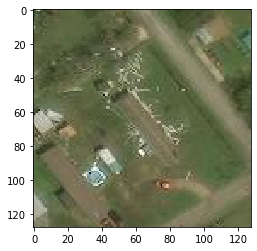

In [26]:
import matplotlib.pyplot as plt
image_copy = test_images[idd].copy()
plt.imshow(image_copy)

In [29]:
temp = a[3][0].copy() #Selecting here the interpretation technique. Selected is the IG
temp = temp/np.abs(temp).max()

In [495]:
image_copy = test_images[idd].copy()
for seg in np.unique(segment):
    weight = temp[seg]
    for dim in range(128):
        indexes = np.where(segment[dim] == seg)[0]
        for index in indexes:
            if weight > 0:
                image_copy[dim][index][0] = image_copy[dim][index][k] + weight
            elif weight < 0:
                image_copy[dim][index][2] = image_copy[dim][index][k] + abs(weight)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


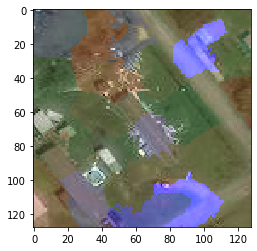

In [496]:
plt.imshow(image_copy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


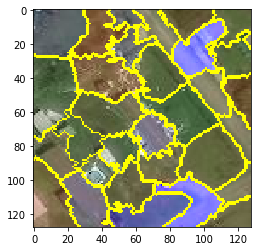

In [510]:
from skimage.segmentation import mark_boundaries
plt.imshow(mark_boundaries(image_copy, segment,
                           mode='inner', background_label=16))
